In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


# <center> Paso 0 - Preprocesamiento (Definicion de variables y funciones)

In [2]:
"""
Definicion de constantes a usar de forma Global
"""

TRAIN_DIR = './input/asl_alphabet_train/asl_alphabet_train'
TEST_DIR= './input/asl_alphabet_test/asl_alphabet_test'

LABELS_DICT = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'N': 13,
    'O': 14,
    'P': 15,
    'Q': 16,
    'R': 17,
    'S': 18,
    'T': 19,
    'U': 20,
    'V': 21,
    'W': 22,
    'X': 23,
    'Y': 24,
    'Z': 25,
    'space': 26,
    'del': 27,
    'nothing': 28,
}

COLUMNS = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'I',
    'J',
    'K',
    'L',
    'M',
    'N',
    'O',
    'P',
    'Q',
    'R',
    'S',
    'T',
    'U',
    'V',
    'W',
    'X',
    'Y',
    'Z',
    'space',
    'del',
    'nothing',
]

In [3]:
def decode(datum):
    """
    Esta es la funcion con la que se obtendra el indice apartir de una lista
    """
    return np.argmax(datum)

def decode_labels(Y_test):
    """
    Esta es la funcion para decodificar las etiquetas de la lista categorica al indice de la lista con la que se puede
    obtener la etiqueta de la letra
    """
    labels_semi_decoded = []
    for i in range(Y_test.shape[0]):

        decoded_datum = decode(Y_test[i])
        labels_semi_decoded.append(decoded_datum)
    return labels_semi_decoded


In [4]:
def load_unique():
    """
    Funcion para cargar datos de entrenamiento
    """
    size_img= 64, 64
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(TRAIN_DIR):
        for file in os.listdir(TRAIN_DIR + '/' + folder):
            filepath = TRAIN_DIR + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

def plot_images(fig, image, label, row, col, index):
    """
    Funcion para analisis inicial de las imagenes en el paso 1
    """
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

def load_data():
    """
    Funcion para cargar los datos con los que se va a entrenar y validar el modelo
    """
    images = []
    labels = []
    size = 64, 64
    print("Cargando...")
    for folder in os.listdir(TRAIN_DIR):
        print(folder, end = ' | ')
        for image in os.listdir(TRAIN_DIR + '/' + folder):
            temp_img = cv2.imread(TRAIN_DIR + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(LABELS_DICT[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    print()
    print('Cargado', len(X_train),'imagenes para entrenamient,','Dimensiones de datos de entrenamiento =',X_train.shape)
    print('Cargado', len(X_test),'imagenes para validacion','Dimensiones de datos de validacion =',X_test.shape)
    return X_train, X_test, Y_train, Y_test

In [5]:
def create_model():
    """
    Funcion para crear el modelo
    """
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = [3, 3], padding = "same", activation = "relu", input_shape = (64, 64, 3)))
    model.add(Conv2D(32, kernel_size = [3, 3], padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = [3, 3]))
    model.add(Conv2D(32, kernel_size = [3, 3], padding = "same", activation = "relu"))
    model.add(Conv2D(64, kernel_size = [3, 3], padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = [3, 3]))
    model.add(Conv2D(128, kernel_size = [3, 3], padding = "same", activation = "relu"))
    model.add(Conv2D(256, kernel_size = [3, 3], padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = [3, 3]))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(29, activation = "softmax"))
    
    model.compile(optimizer = "adam", loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    print("Modelo creado")
    model.summary()
    return model

def fit_model():
    """
    Funcion para entrenar el modelo
    """
    model_hist = model.fit(X_train, Y_train, batch_size = 64, epochs = 6, validation_split = 0.1)
    return model_hist
    
    

In [6]:
def load_test_data():
    images = []
    names = []
    size = 64, 64
    for image in os.listdir(TEST_DIR):
        temp = cv2.imread(TEST_DIR + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
        
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names


def get_labels_for_plot(predictions):
    """
    Funcion para obtener la etiqueta de la letra
    """
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in LABELS_DICT:
            if predictions[i] == LABELS_DICT[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    """
    Funcion para graficar las imagenes en el paso 5 de validacion
    """
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "Prediccion : [%s] \n Real : [%s]" % (predictions_label, label)
    plt.title(title)
    return


# <center> Paso 1 - Analisis de las imagenes

Etiquetas unicas =  ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


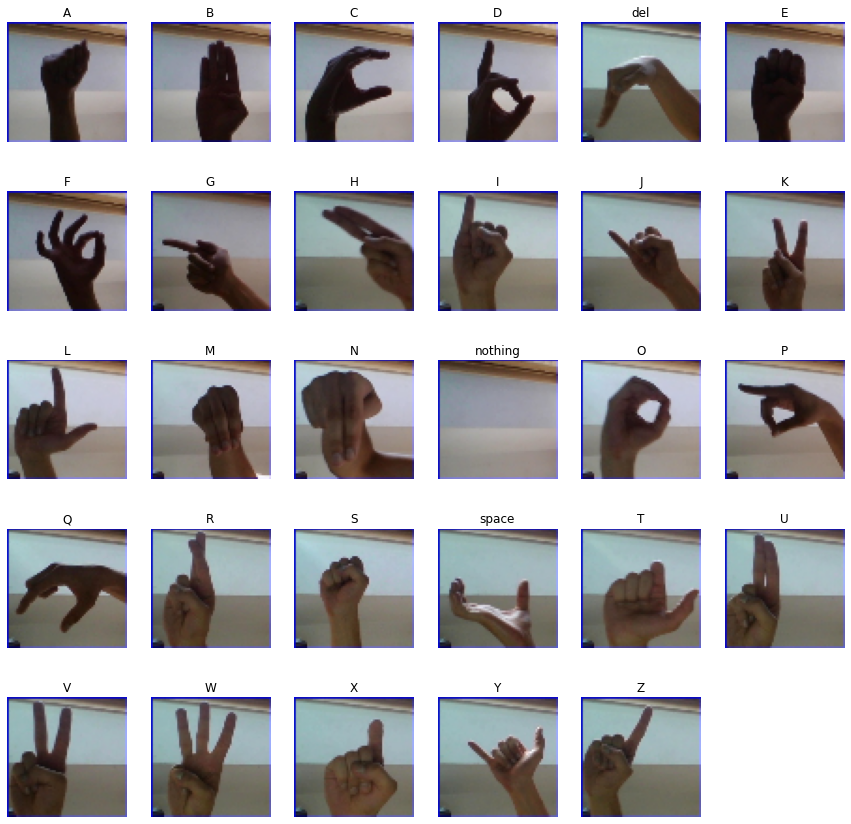

In [7]:
images_for_plot, labels_for_plot = load_unique()
print("Etiquetas unicas = ", labels_for_plot)

fig = plt.figure(figsize = (15, 15))
image_index = 0
row = 5
col = 6
for i in range(1, (row * col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1

plt.show()

# <center> Paso 2 - Preparacion de datos para entrenamiento

In [8]:
X_train, X_test, Y_train, Y_test = load_data()

Cargando...
A | B | C | D | del | E | F | G | H | I | J | K | L | M | N | nothing | O | P | Q | R | S | space | T | U | V | W | X | Y | Z | 
Cargado 82650 imagenes para entrenamient, Dimensiones de datos de entrenamiento = (82650, 64, 64, 3)
Cargado 4350 imagenes para validacion Dimensiones de datos de validacion = (4350, 64, 64, 3)


In [9]:
model = create_model()

Modelo creado
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7

# <center> Paso 4 - Entrenamiento y Metricas iniciales

In [10]:
curr_model_hist = fit_model()

Train on 74385 samples, validate on 8265 samples
Epoch 1/6
74385/74385 [==============================] - 53s 710us/step - loss: 0.8793 - accuracy: 0.8249 - val_loss: 0.2543 - val_accuracy: 0.9770
Epoch 2/6
74385/74385 [==============================] - 43s 578us/step - loss: 0.2124 - accuracy: 0.9747 - val_loss: 0.1439 - val_accuracy: 0.9883
Epoch 3/6
74385/74385 [==============================] - 47s 634us/step - loss: 0.1522 - accuracy: 0.9832 - val_loss: 0.3253 - val_accuracy: 0.9332
Epoch 4/6
74385/74385 [==============================] - 48s 641us/step - loss: 0.1662 - accuracy: 0.9830 - val_loss: 0.1546 - val_accuracy: 0.9920
Epoch 5/6
74385/74385 [==============================] - 47s 629us/step - loss: 0.1293 - accuracy: 0.9890 - val_loss: 0.1391 - val_accuracy: 0.9923
Epoch 6/6
74385/74385 [==============================] - 46s 623us/step - loss: 0.1408 - accuracy: 0.9887 - val_loss: 0.1272 - val_accuracy: 0.9904


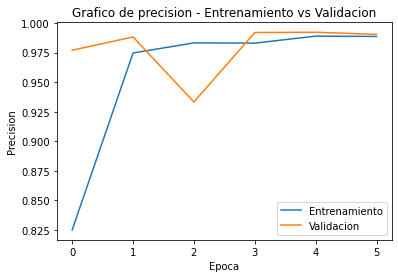

In [11]:
plt.plot(curr_model_hist.history['accuracy'])
plt.plot(curr_model_hist.history['val_accuracy'])
plt.legend(['Entrenamiento','Validacion'], loc = 'lower right')
plt.title('Grafico de precision - Entrenamiento vs Validacion')
plt.xlabel("Epoca")
plt.ylabel("Precision")
plt.show()

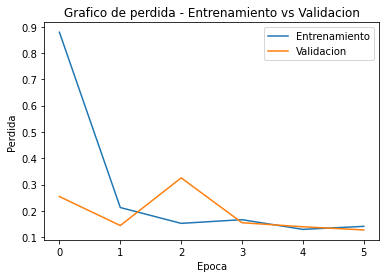

In [12]:
plt.plot(curr_model_hist.history['loss'])
plt.plot(curr_model_hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validacion'], loc = 'upper right')
plt.title('Grafico de perdida - Entrenamiento vs Validacion')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.show()

In [13]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\n Precision de validacion = ", "{:.2f}%".format(evaluate_metrics[1]*100, "\n Perdida de validacion = ", "{:.6f}".format(evaluate_metrics[0])))

4350/4350 [==============================] - 2s 440us/step

 Precision de validacion =  99.03%


# <center> Paso 5 - Validacion del modelo

In [14]:
labels_semi_decoded = decode_labels(Y_test)
predictions = [model.predict_classes(image.reshape(1, 64, 64, 3))[0] for image in X_test]
predictions_labels_plot = get_labels_for_plot(predictions)
tax_labels = get_labels_for_plot(labels_semi_decoded)

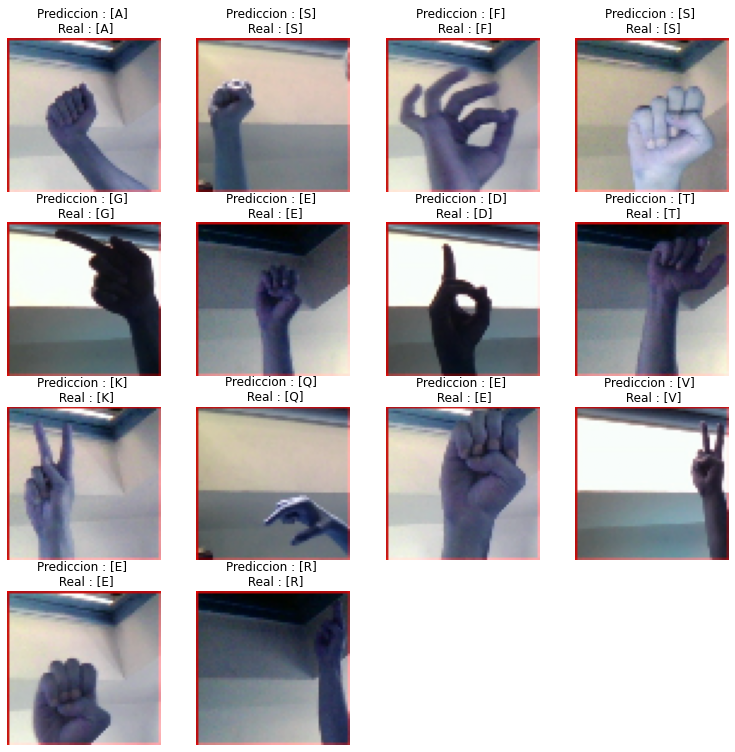

In [15]:
predfigure = plt.figure(figsize = (13, 13))
image_index = 0
row = 4
col = 4
for i in range(1, (row * col - 1)):
    
    plot_image_1(
        predfigure, 
        X_test[image_index], 
        tax_labels[image_index],
        predictions[image_index],
        predictions_labels_plot[image_index],
        row,
        col,
        i)
    image_index = image_index + 1
plt.show()

# <center> Paso 6 - Analisis de resultados

In [16]:
con_mat = tf.math.confusion_matrix(labels=labels_semi_decoded, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = COLUMNS, 
                     columns = COLUMNS)

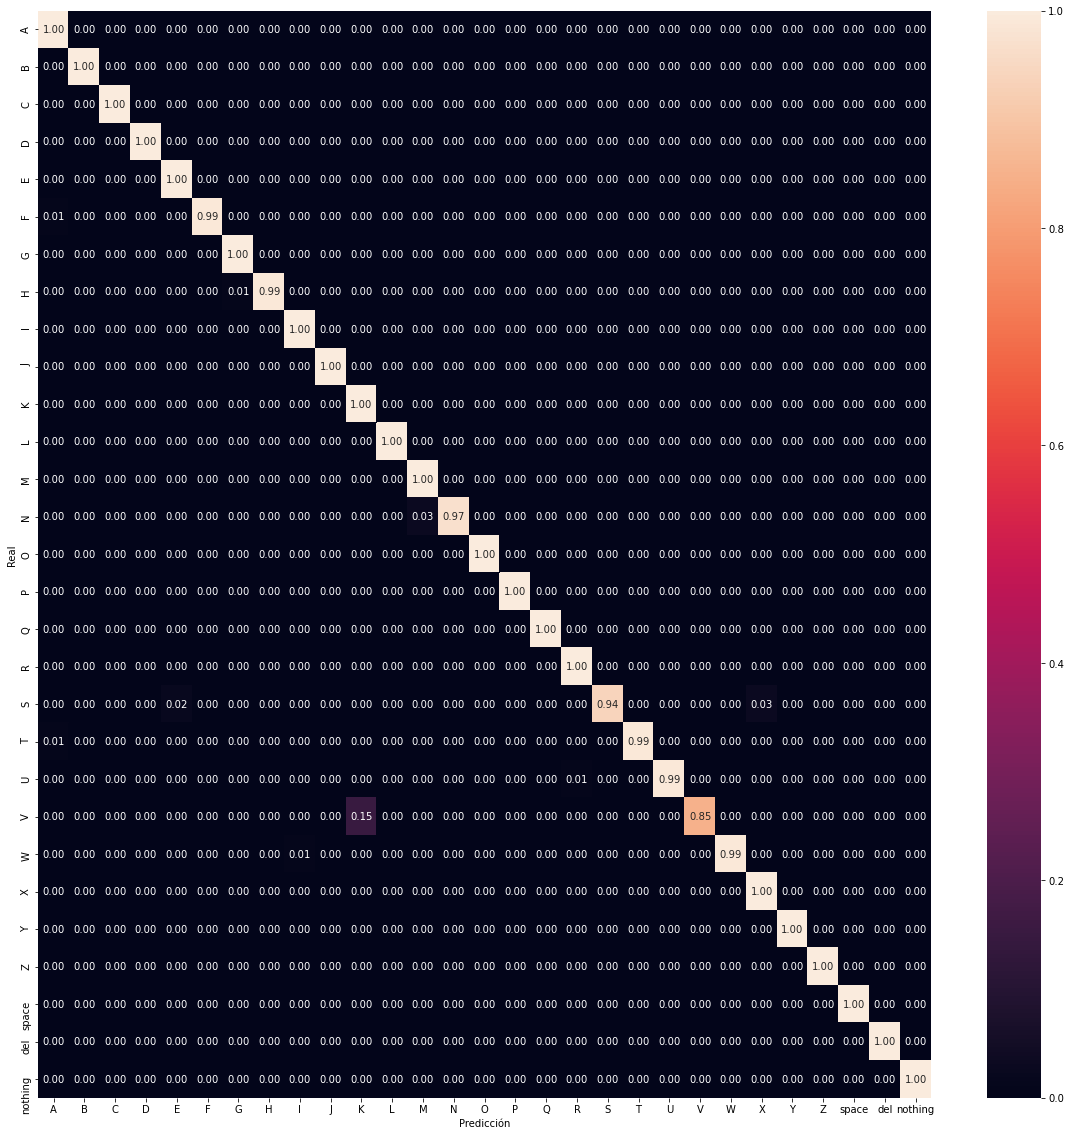

In [17]:
figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True, fmt='.2f', xticklabels=COLUMNS, yticklabels=COLUMNS)
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

In [20]:
# validation_images, validation_img_names = load_validation_data()
# predictions = [model.predict_classes(image.reshape(1, 64, 64, 3))[0] for image in validation_images]

In [21]:
# predictions_labels_plot = get_labels_for_plot(predictions)

In [22]:
# predfigure = plt.figure(figsize = (20, 20))
# image_index = 0
# row = 6
# col = 3
# for i in range(1, (row * col - 1)):
#     plot_image_1(
#         predfigure, 
#         validation_images[image_index], 
#         validation_img_names[image_index],
#         predictions[image_index],
#         predictions_labels_plot[image_index],
#         row,
#         col,
#         i)
#     image_index = image_index + 1
# plt.show()

In [23]:
"""
Aqui hacemos magia negra
Vamos a exportarlo tal cual
"""
# Se exporta el modelo al formato YAML
model_yaml = model.to_yaml()
with open("model_12_03_2020.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# Se guardan los pesos en el formato en HDF5
model.save_weights("model_12_03_2020.h5")


